In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

### 【問題1】パイプラインの作成
授業前課題で行ったことを参考に、学習し推定結果を出すまでの一連の流れを行ってください。テストデータに対して推定を行い、それをKaggleに提出してみましょう。この段階では高い精度を出す必要はありません。

### パイプライン関数

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

def pipline(model, data, target_value, feature_value, positive_label, normalization=True, plot=True):
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    
    #学習データ、テストデータに分ける
    train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
    train_feature = train_data[feature_value].values
    train_target = train_data[target_value].values
    test_feature = test_data[feature_value].values
    test_target = test_data[target_value].values
    print("元データ数：{}　学習データ数：{}　検証データ数：{}".format(len(data), len(train_data), len(test_data)))
    
    #学習データの特徴量を標準化
    if normalization == True:
        scaler = StandardScaler()
        scaler.fit(train_feature)
        train_feature = scaler.transform(train_feature)
        scaler.fit(test_feature)
        test_feature = scaler.transform(test_feature)

    #学習と予測
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
    
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target.reshape(-1), result[:,0], pos_label=positive_label)
    #rocをplot
    if plot == True:
        plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
        plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.ylim([0.0, 1.0])
        plt.xlim([0.0, 1.0])
        plt.show()
    
    return fpr, tpr, thresholds

### 試しにirisデータで評価してみる

In [3]:
from sklearn.datasets import load_iris
iris_data_set = load_iris()
x = pd.DataFrame(iris_data_set.data, columns=iris_data_set.feature_names)    #Put explanatory variable into x as pandasdata frame
y = pd.DataFrame(iris_data_set.target, columns=['Species'])    #Put iris response variable into y as pandasdata frame
df = pd.concat([x, y], axis=1)
data = df[df["Species"] != 0]

元データ数：100　学習データ数：75　検証データ数：25


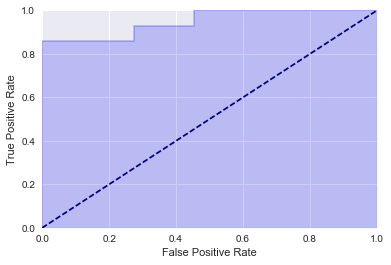

AUC=0.95130


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=10)
#clf = KNeighborsClassifier(n_neighbors=3)

fpr, tpr, thresholds = pipline(clf, data, "Species", data.columns[[0,2]], 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

### 実際に計算

特徴量を選ぶ(とりあえず前回のEDAの結果)
1.OCCUPATION_TYPE  
2.ORGANIZATION_TYPE  
5.DAYS_EMPLOYED  
6.DAYS_REGISTRATION  
7.AMT_CREDIT  
8.DAYS_BIRTH  
9.DEF_60_CNT_SOCIAL_CIRCLE  
10.AMT_INCOME_TOTAL  
11.CNT_CHILDREN  

In [5]:
import copy
"""
selected_feature_name = ["OCCUPATION_TYPE", 
                         "ORGANIZATION_TYPE", 
                         "DAYS_EMPLOYED", 
                         "DAYS_REGISTRATION", 
                         "AMT_CREDIT", "DAYS_BIRTH", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", 
                         "AMT_INCOME_TOTAL", 
                         "CNT_CHILDREN"]
"""
selected_feature_name = ["OCCUPATION_TYPE", 
                         "ORGANIZATION_TYPE",
                         "EXT_SOURCE_1",
                         "EXT_SOURCE_2",
                         "DAYS_EMPLOYED", 
                         "DAYS_REGISTRATION", 
                         "AMT_CREDIT", 
                         "DAYS_BIRTH", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", 
                         "AMT_INCOME_TOTAL", 
                         "CNT_CHILDREN"]
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [6]:
pd_application_train = pd.read_csv("/Users/naoki/Desktop/DIC/week3/session/all/application_train.csv")
pd.options.display.max_columns = len(pd_application_train.columns)

In [7]:
pd_reducted_train_data = pd_application_train[col_name]

In [8]:
#オブジェクト型データをエンコーディング
object_data_home_credit = pd_reducted_train_data.select_dtypes(['object'])
object_col_name = object_data_home_credit.columns.values
array_object_to_int = np.array([object_data_home_credit[object_col_name[i]].unique() for i in range(0,len(object_col_name))])

#オブジェクト型を数値に置き換え
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_reducted_train_data[object_col_name[i]])
    pd_reducted_train_data[object_col_name[i]] = labels    

pd_reducted_train_data = pd_reducted_train_data.replace(np.nan, -1)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


元データ数：307511　学習データ数：230633　検証データ数：76878


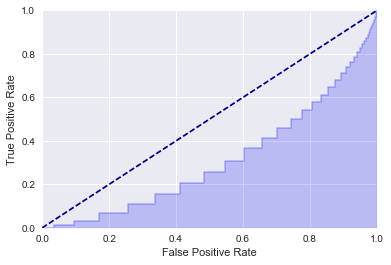

AUC=0.32907


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#clf = KNeighborsClassifier(n_neighbors=5)
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=10)
fpr, tpr, thresholds = pipline(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

### 【問題2】指標値の関数作成
このコンペティションでは提出した確率から指標値 AUC が計算され、それで順位が決まります。（Evaluationのページ参照）
このAUCを計算する関数を作成してください。

In [10]:
def cal_auc(fpr, tpr):
    
    dx = fpr[1:]-fpr[:-1]     #X軸（fpr）について配列の隣同士の間隔を計算
    dy = (tpr[1:]+tpr[:-1])/2 #Y軸(tpr)について配列の右隣との平均値を計算
    integral = dx*dy
    """
    integral_under = dx * tpr[0:len(tpr)-1]
    integral_over = dx * tpr[1:len(tpr)]
    auc = (integral_under.sum()+integral_over.sum())/2
    """
    return integral.sum()

#### AUCを計算 (Sklearn Metric.aucの計算結果と比較)

In [11]:
print("AUC(with cal_auc)={:.6f}".format(cal_auc(fpr, tpr)))
print("AUC(with metrics.auc)={:.6f}".format(metrics.auc(fpr, tpr)))

AUC(with cal_auc)=0.329070
AUC(with metrics.auc)=0.329070


### 【問題3】前処理・Feature Engineering・学習
精度を上げるために前処理・Feature Engineeringを行ってください。そしてその特徴量によって学習、検証、再び前処理の流れを繰り返しましょう。この工程はEDAの続きとも言えます。Week3で学んだことを思い出しながら進めてください。
汎化性能が高いモデルが作成できたと判断した場合は再びKaggleに提出をしましょう。

#### EDA 続き　新しい特徴量を出そう
1.顧客の性格、周辺環境などを数値化  
    いい加減さ、家族有/無、友人関係など、複数ローンを持っているかなど  
2.新しい特徴量でとりあえず分類結果を見る

1-1. いい加減さを数値化   
＊収入が低いのに子供が多い人は無計画  
＊仕事が長続きしない  
＊若くないのに未婚は何か理由がある  
＊収入低いのに多く借りている  
＊Nanの欄が多い

1-2. 家族有り無しを0,1に

1-3. 周辺環境の良し悪しを数値化